In [1]:
%matplotlib inline
from IPython.display import clear_output
from matplotlib import pyplot as plt
import pandas as pd

## Build loss function

In [123]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def chose_from_action_dist(a_dist):
    """From the NN output, draw an action from the outputted action distribution"""
    picked_action_prob = np.random.choice(a_dist[0], p=a_dist[0])
    return np.argmax(a_dist == picked_action_prob)

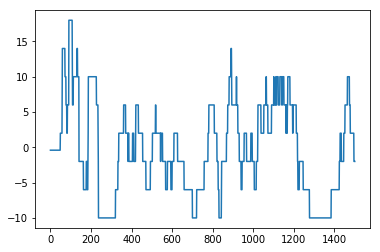

KeyboardInterrupt: 

In [127]:
import json
import os
import sys
import time

import numpy as np
import tensorflow as tf

import tetris_api
import tf_rl_utils

from collections import OrderedDict

ACTIONS = {3: 'up', 2: 'right', 1: 'left', 0: 'down'}

if sys.version_info.major == 2:
    range = xrange

# tetris
num_cols = 10
num_rows = 20

# learning params
gamma = 0.9
learning_rate = 1e-2
max_ep = 99999 # how many steps to take
num_hidden = 25
update_frequency = 25 # after how many games to update model

# tf stuff init 
tf.reset_default_graph()  # clear the Tensorflow graph.
sess = tf.InteractiveSession()

# build nodes
x = tf.placeholder(tf.float32, shape=[None, num_cols*num_rows])
actions = tf.placeholder(tf.int32, shape=[None])
rewards = tf.placeholder(tf.float32, shape=[None])

# 1st layer 
W1 = weight_variable([num_cols*num_rows, num_hidden])
b1 = bias_variable([num_hidden])
h1 = tf.nn.relu(tf.matmul(x, W1) + b1)
 
# output 
W2 = weight_variable([num_hidden, 4])
b2 = bias_variable([4])
y = tf.matmul(h1,W2) + b2
output = tf.nn.softmax(y)

# get prob for chosen action
# first need to figure out indices of all of the chose actions
# from the flattened array
action_indices = (tf.range(0, tf.shape(y)[0]) * tf.shape(y)[1]) + actions
prob_for_picked_actions = tf.gather(tf.reshape(output, [-1]), action_indices)

# loss function
cross_entropy = -tf.reduce_mean(tf.log(prob_for_picked_actions) * rewards)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# initialize variables
sess.run(tf.global_variables_initializer())

env = tetris_api.PyTetrisEnv()
all_ep_history = []
game_num = 0
games_rewards = []
batch_start_time = time.time()
batch_num_moves = 0
while True:
    s_2D, _, _, _ = env.reset(number_of_rows=num_rows, number_of_cols=num_cols)
    s = tf_rl_utils.prepro(s_2D)
    prior_state = np.zeros_like(s)
    ep_history = []
    for j in range(max_ep):
        batch_num_moves += 1
        # determine action
        del_state = s - prior_state 
        action_distribution = sess.run(output,
                                       feed_dict={x: [del_state]})
        action = chose_from_action_dist(action_distribution)
        
        # take action
        prior_state = s
        s_2D, r, done, _ = env.step(ACTIONS[action]) 
        s = tf_rl_utils.prepro(s_2D)
        
        ep_history.append(np.array([del_state, action, r]))
        if done:
            ep_history = np.array(ep_history)
            r = tf_rl_utils.discount_rewards(ep_history[:, 2], gamma=gamma)
            ep_history[:, 2] = r
            all_ep_history.append(ep_history)
            games_rewards.append(np.sum(r))
            ep_history = []

            its_time_to_update_weights = ((game_num % update_frequency) == 0 and (game_num != 0))
            if its_time_to_update_weights:
                print "n moves: {}, to play batch: {}".format(batch_num_moves, time.time() - batch_start_time)
                print game_num, '{:2.2f}'.format(np.mean(games_rewards[game_num-10:game_num]))
                batch_start_time = time.time()
                weight_update_start = time.time()
                all_ep_history = np.vstack(all_ep_history)
                feed_dict = {rewards: all_ep_history[:, 2],
                             actions: all_ep_history[:, 1],
                             x: np.vstack(all_ep_history[:, 0])}
                sess.run(train_step,
                         feed_dict=feed_dict)
                print "to update weight: ", time.time() - weight_update_start
                
                # book keeping
                all_ep_history = []
                batch_num_moves = 0
                
                
                its_time_to_plot = ((game_num % 500) == 0 and (game_num != 0))
                if its_time_to_plot:
                    clear_output()
                    game_rewards_s = pd.Series(games_rewards)
                    rolling_game_rewards = game_rewards_s.rolling(50).mean().fillna(game_rewards_s.mean())
                    plt.plot(rolling_game_rewards)
                    plt.show()
            break
    game_num += 1
# TODO: fix normalize gradients
# maybe scale input?

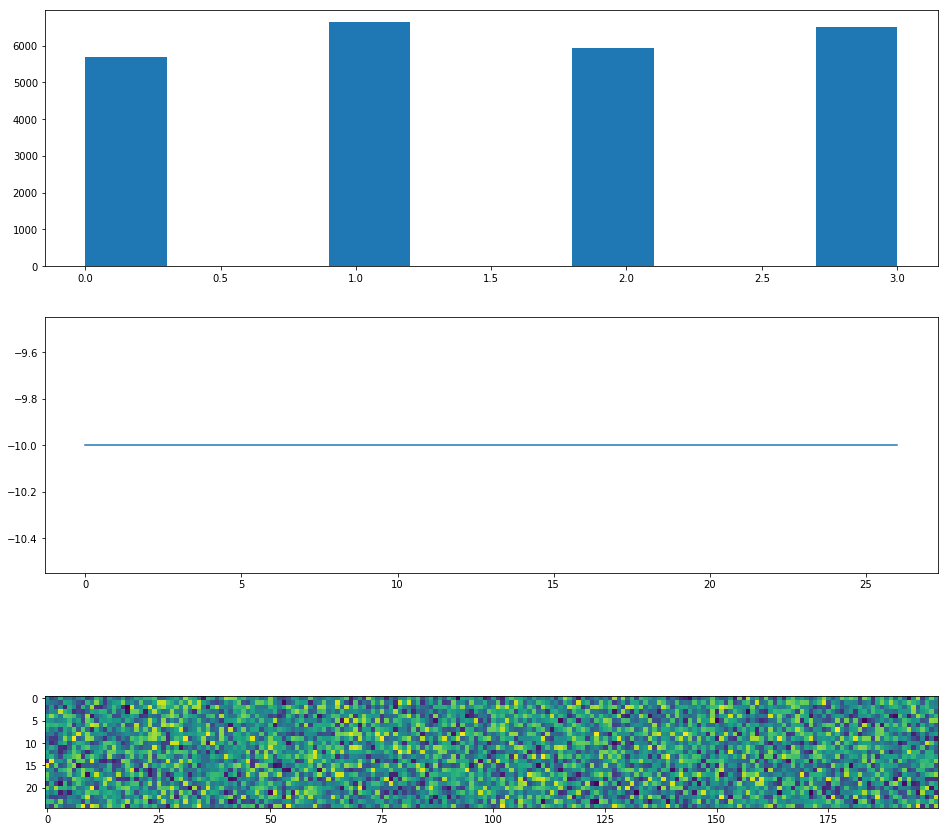

In [5]:
fig,(ax0,ax1,ax2) = plt.subplots(3,1, figsize=(16,16))
ax0.hist(action_history)

# game rewards
# ax1.plot(game_rewards)
game_rewards_s = pd.Series(game_rewards)
rolling_game_rewards = game_rewards_s.rolling(50).mean().fillna(game_rewards_s.mean())
ax1.plot(rolling_game_rewards)

# weights
_W = sess.run(W1)
c = ax2.imshow(_W.T)
# c.colorbar()

play games

features:
* viz
    * include score board
    * |___| 
    
* return
    * #games
    * #games/second
    * longest game
    * shortest game
    * best game
    * worst game
    * num down, up, left, right
    * min reward, max reward
    * game rewards
    
* args
    * player {random, machine, human}
    * game size
    * play games




* view game 
* input:
    * game, rewards
* output viz

In [51]:
def take_random_action(_):
    return np.random.randint(0,4)

class RL_Agent(object):
    
    def __init__(self, sess, output):
        self.sess = sess
        self.output = output
        
    def take_action(self, s):
        a_dist = self.sess.run(self.output, feed_dict={x: [s]})
        return chose_from_action_dist (a_dist)

    
def viz_game(game_states, game_rewards, frame_delay=.02):
    """For replaying games, helpful for debugging
    and visualizing performance"""
    num_moves = 0
    score = 0
    score_board = 'n: {}  score: {}'
    for state, reward in zip(game_states, game_rewards):
        clear_output(wait=True)
        num_moves += 1
        score += reward
        print state 
        print score_board.format(num_moves, score)
        time.sleep(.02) 

def play_games(num_games, board_size, player, viz=False):
    """We want to be able to watch our trained agent play. Or a random agent. Or a human.
    Given a player, play num_games and return a bunch of stats about the games played. 
    """
    num_rows, num_cols = board_size
    env = tetris_api.PyTetrisEnv()
    
    # book keeping
    start_time = time.time()
    action_count = {'up': 0, 'down': 0, 'left': 0, 'right': 0}
    current_best_score = 0
    n_moves = 0
    games_rewards = []
    games_n_moves = []
    best_game_states = []
    best_game_rewards = []
    
    
    for game_id in range(num_games):
        # start new game
        s_2D, _, _, _ = env.reset(number_of_rows=num_rows, number_of_cols=num_cols)
        s = tf_rl_utils.prepro(s_2D)
        prior_state = np.zeros_like(s)
        
        # keep track of high-level game info 
        reward_sum = 0
        game_n_moves = 0
        game_start_time = time.time()
        # keep track of move-level params, in case we want to viz
        game_states = [env.game.print_board()]
        game_rewards = [0]
        
        for move_num in range(max_ep):
            # determine action
            del_state = s - prior_state 
            action = player(del_state)

            # take action
            prior_state = s
            s_2D, r, done, _ = env.step(ACTIONS[action]) 
            
            # book keeping
            action_nm = ACTIONS[action]
            action_count[action_nm] = action_count[action_nm] + 1
            game_n_moves += 1
            reward_sum += r
            s = tf_rl_utils.prepro(s_2D)
            
            # for viz purposes
            game_states.append(env.game.print_board())
            game_rewards.append(r)
            
            if done:
                n_moves += game_n_moves
                games_n_moves.append(game_n_moves)
                games_rewards.append(reward_sum)
                if reward_sum > current_best_score:
                    best_game_states.append(game_states)
                    best_game_rewards.append(game_rewards)
                if viz:
                    viz_game(game_states, game_rewards, frame_delay=.02)
                break
                
    # organize results and return
    total_time =  time.time() - start_time
    game_rewards = np.array(game_rewards)
    game_n_moves = np.array(game_n_moves)
    game_summary_dict = OrderedDict([('total_time', total_time),
                                     ('total_moves', n_moves),
                                    
                                     ('avg_moves_per_game', n_moves/float(num_games)),
                                     ('avg_reward_per_game', np.sum(games_rewards)/float(num_games)),
                                    
                                     ('indiv_game_rewards', [games_rewards]),
                                     ('indiv_game_n_moves', [games_n_moves]),
                                    
                                     ('max_moves', np.max(games_n_moves)),
                                     ('min_moves', np.min(games_n_moves)),
                                     ('best_game' , np.max(games_rewards)),
                                     ('worst_game', np.min(games_rewards)),
                                    
                                     ('total_down', action_count['down']),
                                     ('total_up', action_count['up']),
                                     ('total_left', action_count['left']),
                                     ('total_right', action_count['right']),
                                    
                                     ('best_game_states', [best_game_states]),
                                     ('best_game_rewards', [best_game_rewards])
                                    ])
    return pd.DataFrame(game_summary_dict, index = ['value']).T

1

In [ ]:
rl_agent = RL_Agent(sess, output)
res = play_games(25, (num_rows, num_cols), take_random_action, viz=False)


In [120]:
# watch best game
r = res.loc['indiv_game_rewards']
best_game_states = res.loc['best_game_states'][0][0]
best_game_rewards = res.loc['best_game_rewards'][0][0]

viz_game(best_game_states, best_game_rewards)


|1 1                 |
|1 1                 |
|1 1                 |
|1 1                 |
|  1 1               |
|  1 1               |
|1 1                 |
|1 1                 |
|  1 1         1 1   |
|  1 1         1 1   |
|1 1 1 1 1 1 1 1     |
|1 1 1 1 1 1 1 1     |
|  1 1     1 1       |
|  1 1     1 1       |
|    1 1 1 1         |
|    1 1 1 1         |
|      1 1 1 1   1 1 |
|      1 1 1 1   1 1 |
|1 1   1 1 1 1 1 1   |
|1 1   1 1 1 1 1 1   |
______________________
n: 1124  score: 19.0


<module 'tensorflow' from '/Users/crawles/anaconda/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

## Appendix
### View loss

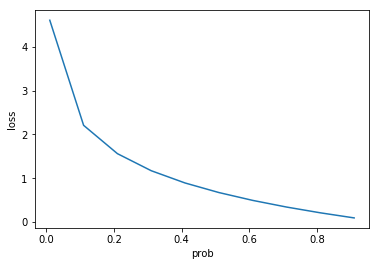

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

probs = np.arange(0.01,1,0.1)
reward = 1
loss = -reward*(np.log(probs))
plt.plot(probs, loss)
plt.ylabel('loss')
plt.xlabel('prob')